In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from torch import cuda
from tqdm import tqdm
from transformers import BertConfig
from transformers import BertModel
import json
import matplotlib.pyplot as plt
import os
import pickle


import json
import pandas as pd
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
os.environ["TOKENIZERS_PARALLELISM"] = "true"

FINETUNED_MODEL_PATH = "Bert_Model/finetuned_model/maxseq_17_tokencls_lr_1e-06/checkpoint_epoch19"

config = BertConfig.from_pretrained(FINETUNED_MODEL_PATH)

config.num_labels = 3

MAX_LEN = 17
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
ADD_SPECIAL_TOKENS = False


def load_json(path):
    with open(path, "r") as f:
        data = json.load(f)
    return data


fast_tokenizer_args = load_json(
    "Bert_Model/pretraining_code/Protein/tokenizer_output_files/BertWordPieceTokenizer/fast_tokenizer_args.json"
)
tokenizer = BertTokenizerFast.from_pretrained(
    "Bert_Model/pretraining_code/Protein/tokenizer_output_files/BertWordPieceTokenizer",
    **fast_tokenizer_args
)


test_data = pd.read_csv("Bert_Model/new_17resid_test_data.txt", encoding='unicode_escape', names=['Seq'])
test_target = pd.read_csv("Bert_Model/Ntest_3states_target.txt", encoding='unicode_escape', names=['target'])

df_ = pd.concat([test_data, test_target], axis=1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

label_set = df_.target.unique().tolist() 


def batchify(l, batch_size):
    i = 0
    while i < len(l):
        i += batch_size
        yield l[i - batch_size:i]


def make_dataset(df):
    train_x = []
    train_y = []

    for _, row in tqdm(df.iterrows(), total=len(df)):

        window_size = len(list(row.Seq.strip()))

        sent = " ".join(list(row.Seq.strip()))
        sent = sent.replace("B", "[PAD]")
        train_x.append(sent)

        word_labels = row.target
        labels = [word_labels]

        if ADD_SPECIAL_TOKENS == True:
            labels = [-100] + labels

        labels = [-100] * (window_size // 2) + labels
        labels = labels + [-100] * (MAX_LEN - len(labels))
        labels = labels[:MAX_LEN]
        train_y.append(labels)

    input_ids_train = []
    attention_mask_train = []

    for batch in tqdm(batchify(train_x, 500), total=len(train_x) // 500):
        tok = tokenizer(
            batch,
            return_attention_mask=True,
            padding='max_length',
            add_special_tokens=ADD_SPECIAL_TOKENS,
            truncation=True,
            max_length=MAX_LEN
        )
        input_ids_train += tok["input_ids"]
        attention_mask_train += tok["attention_mask"]

    input_ids_train = torch.LongTensor(input_ids_train)
    attention_mask_train = torch.LongTensor(attention_mask_train)
    train_y = torch.LongTensor(train_y)
    training_set = TensorDataset(input_ids_train, attention_mask_train, train_y)
    return training_set

model = BertForTokenClassification.from_pretrained(FINETUNED_MODEL_PATH, config=config)


def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)


def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)

        
if os.path.exists("cached_testing_set.pickle"):
    print("\t LOADING testing_set FROM CACHE")
    testing_set = read_pickle("cached_testing_set.pickle")
else:
    testing_set = make_dataset(df_)
    save_pickle(testing_set, "cached_testing_set.pickle")

test_params = {
    'batch_size': 128,
    'shuffle': False,
    'num_workers': 0,
}
testing_loader = DataLoader(testing_set, **test_params)


def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(testing_loader)):
            ids, mask, labels = batch
            ids = ids.to(device)
            mask = mask.to(device)
            labels = labels.to(device)

            out = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = out["loss"]
            eval_logits = out["logits"]
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

            # if idx % 100 == 0:
            #     loss_step = eval_loss / nb_eval_steps
            #     print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = labels.view(-1)  # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels)  # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1)  # shape (batch_size * seq_len,)

            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100  # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [id.item() for id in eval_labels]
    predictions = [id.item() for id in eval_preds]

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps

    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss, eval_accuracy

	 LOADING testing_set FROM CACHE


In [2]:
# model.to(device)
# print(FINETUNED_MODEL_PATH.split("/")[-1])
# labels, predictions, eval_loss, eval_accuracy = valid(model, testing_loader)

In [3]:
# import pandas as pd
# pred_summary_test = pd.DataFrame({
#     "real": labels,
#     "pred": predictions,
# })
# pred_summary_test.to_pickle(f'Bert_Model/finetuned_model/maxseq_17_tokencls_lr_1e-06/pred_summary_test.pickle')
# pred_summary_test

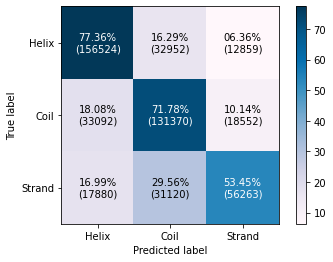

In [4]:
import pandas as pd
from sklearn.metrics import confusion_matrix
pred_summary_test = pd.read_pickle(f'Bert_Model/finetuned_model/maxseq_17_tokencls_lr_1e-06/pred_summary_test.pickle')

df = pred_summary_test
M=confusion_matrix(df.real.tolist(), df.pred.tolist())
M_norm = (M.T/M.sum(1)).T*100
heatmap = plt.imshow(M_norm, cmap="PuBu")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0,1,2], ["Helix","Coil","Strand"])
plt.yticks([0,1,2], ["Helix","Coil","Strand"])
for x in range(3):
    for y in range(3):
        
        perc = str(round(M_norm[y,x]/100,4)).ljust(6,'0')[2:]
        perc = perc[:2]+"."+perc[2:]
        
        plt.text(
            x,y,
            f"{perc}%\n({M[y,x]})",
            ha="center",
            va="center",
            c="w" if M_norm[y,x]>50 else "k"
        )
        
plt.colorbar(heatmap)
plt.savefig(f"plots/BERT_Model.confmat_test.pdf", dpi=300)
plt.show()

In [5]:
import torch.nn as nn
from captum.attr import DeepLift

def compute_bert_outputs(model_bert, embedding_output, attention_mask=None, head_mask=None,
                         model_class=BertForTokenClassification):
    if attention_mask is None:
        attention_mask = torch.ones(embedding_output.shape[0], embedding_output.shape[1]).to(embedding_output)

    extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

    extended_attention_mask = extended_attention_mask.to(
        dtype=next(model_bert.parameters()).dtype)  # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

    if head_mask is not None:
        if head_mask.dim() == 1:
            head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            head_mask = head_mask.expand(model_bert.config.num_hidden_layers, -1, -1, -1, -1)
        elif head_mask.dim() == 2:
            head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # We can specify head_mask for each layer
        head_mask = head_mask.to(
            dtype=next(model_bert.parameters()).dtype)  # switch to fload if need + fp16 compatibility
    else:
        head_mask = [None] * model_bert.config.num_hidden_layers

    encoder_outputs = model_bert.encoder(embedding_output,
                                         extended_attention_mask,
                                         head_mask=head_mask)

    sequence_output = encoder_outputs[0]

    # if model_class == BertForSequenceClassification:
    #     pooled_output = model_bert.pooler(sequence_output)
    #     outputs = (sequence_output, pooled_output) + encoder_outputs[
    #                                                  1:]  # add hidden_states and attentions if they are here
    #     return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)
    if model_class == BertForTokenClassification:
        outputs = (sequence_output,) + encoder_outputs[1:]  # add hidden_states and attentions if they are here
        return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)


class BertModelWrapper(nn.Module):

    def __init__(self, model):
        super(BertModelWrapper, self).__init__()
        self.model = model

    def forward(self, embeddings, attention_mask=None, head_mask=None, position=0):
        model_class = type(self.model)
        outputs = compute_bert_outputs(
            self.model.bert,
            embeddings,
            attention_mask=attention_mask,
            head_mask=head_mask,
            model_class=model_class
        )
        # if model_class == BertForSequenceClassification:
        #     pooled_output = outputs[1]
        if model_class == BertForTokenClassification:
            pooled_output = outputs[0]
        pooled_output = self.model.dropout(pooled_output)
        logits = self.model.classifier(pooled_output)
        logits = logits[:, position, :]
        return logits  # .argmax(1)


bert_model_wrapper = BertModelWrapper(model)
dl = DeepLift(bert_model_wrapper)

def interpret_sentence(model_wrapper, sentence, label=1, position=0, plot=True, max_len=None):
    model_wrapper.eval()
    model_wrapper.zero_grad()
    max_len = model_wrapper.model.config.max_position_embeddings if max_len is None else max_len

    tok_out = tokenizer(sentence, add_special_tokens=False, padding="max_length", max_length=max_len)

    input_ids = torch.tensor(tok_out.input_ids)
    baseline_input_ids = torch.ones_like(input_ids) * tokenizer.pad_token_id

    attention_mask = torch.tensor(tok_out.attention_mask)
    
    input_ids=input_ids.to(device)
    baseline_input_ids=baseline_input_ids.to(device)
    
    input_embedding = model_wrapper.model.bert.embeddings(input_ids)
    baseline_input_embedding = model_wrapper.model.bert.embeddings(baseline_input_ids)

    # predict
    pred = model_wrapper(input_embedding)  # .item()
    
    # print(pred)
    # print(model_wrapper(baseline_input_embedding))
    
    pred_ind = pred.argmax().item()  # round(pred)
    
    # compute attributions and approximation delta using integrated gradients
    # if CAPTUM_ALG == IntegratedGradients:
    #     attributions_ig, delta = ig.attribute(input_embedding, n_steps=2, target=label)
    # elif CAPTUM_ALG == Saliency or CAPTUM_ALG == FeatureAblation or CAPTUM_ALG == DeepLift:
    #     attributions_ig = ig.attribute(
    #         input_embedding,
    #         target=label,
    #         baselines=baseline_input_embedding,
    #         additional_forward_args=(None, None, position)
    #     )
    attributions_ig = dl.attribute(
            input_embedding,
            target=label,
            baselines=baseline_input_embedding,
            additional_forward_args=(None, None, position)
    )

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().cpu().numpy().tolist())

    attributions = attributions_ig.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions, dim=-1).unsqueeze(-1)
    if len(attributions.shape) == 1:
        attributions = attributions.unsqueeze(0)
    attributions = attributions.detach().cpu().numpy()
    # attributions = np.mean(attributions, axis=0)
    attributions = np.mean(np.absolute(attributions), axis=0)

    if plot:
        visualize_importances(tokens, attributions, log=False)
    # return tokens, attributions, pred, pred_ind, label
    return attributions

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True,
                          axis_title="Features", log=False):
    print(title)
    x_pos = [x for x in range(len(feature_names))]
    if plot:
        # plt.figure(figsize=(6, 4))
        plt.plot(x_pos, importances)
        # plt.bar(x_pos, importances, align='center')
        #         plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        if log:
            plt.yscale('log')
        plt.title(title)
        plt.tight_layout()
        # plt.show()

In [6]:
bert_model_wrapper.to(device)

df_["x"] = df_.Seq.apply(lambda val: " ".join([x.replace("B", "[PAD]") for x in val]))
df_

,Seq,target,x
0,BBBBBBBBAAADGDDSL,1,[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD...
1,BBBBBBBAAADGDDSLY,1,[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] A A ...
2,BBBBBBAAADGDDSLYP,1,[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] A A A D G ...
3,BBBBBAAADGDDSLYPI,1,[PAD] [PAD] [PAD] [PAD] [PAD] A A A D G D D S ...
4,BBBBAAADGDDSLYPIA,1,[PAD] [PAD] [PAD] [PAD] A A A D G D D S L Y P I A
...,...,...,...
490607,FKEELEKKGLGGKBBBB,1,F K E E L E K K G L G G K [PAD] [PAD] [PAD] [PAD]
490608,KEELEKKGLGGKBBBBB,1,K E E L E K K G L G G K [PAD] [PAD] [PAD] [PAD...
490609,EELEKKGLGGKBBBBBB,1,E E L E K K G L G G K [PAD] [PAD] [PAD] [PAD] ...
490610,ELEKKGLGGKBBBBBBB,1,E L E K K G L G G K [PAD] [PAD] [PAD] [PAD] [P...


In [7]:
def batchify(l, batch_size):
    i = 0
    while i < len(l):
        i += batch_size
        yield l[i-batch_size:i]

In [8]:
sent_0 = df_.x[df_.target==0].tolist()
attrib_0 = []
for sent_batch in tqdm(batchify(sent_0, 100), total=len(sent_0)//100):
    attrib = interpret_sentence(
        bert_model_wrapper,
        sentence=sent_batch,
        label=0,
        max_len=17,
        position=8,
        plot=False
    )
    attrib_0.append(attrib)
sent_1 = df_.x[df_.target==1].tolist()
attrib_1 = []
for sent_batch in tqdm(batchify(sent_1, 100), total=len(sent_1)//100):
    attrib = interpret_sentence(
        bert_model_wrapper,
        sentence=sent_batch,
        label=1,
        max_len=17,
        position=8,
        plot=False
    )
    attrib_1.append(attrib)
    
sent_2 = df_.x[df_.target==2].tolist()
attrib_2 = []
for sent_batch in tqdm(batchify(sent_2, 100), total=len(sent_2)//100):
    attrib = interpret_sentence(
        bert_model_wrapper,
        sentence=sent_batch,
        label=2,
        max_len=17,
        position=8,
        plot=False
    )
    attrib_2.append(attrib)

  0%|                                                                                          | 0/2023 [00:00<?, ?it/s]/media/HDD/bportelli/env/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
2024it [02:36, 12.90it/s]                                                                                               
1831it [02:25, 12.55it/s]                                                                                               
1053it [01:23, 12.63it/s]                                                                                               


In [9]:
avg_0 = np.mean(attrib_0, axis=0)
avg_1 = np.mean(attrib_1, axis=0)
avg_2 = np.mean(attrib_2, axis=0)

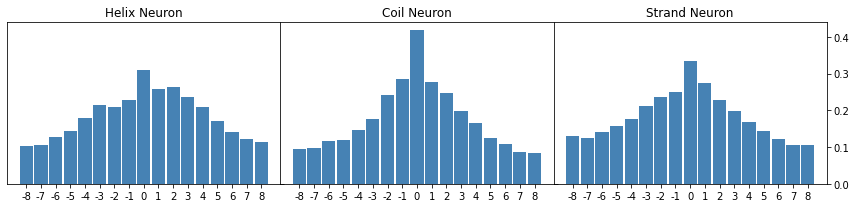

In [11]:
LABELS = ["-"+str(x) for x in range(8,0,-1)]+[str(0)]+[str(x) for x in range(1,9,1)]

def get_sign_color(w0, pos="steelblue", neg="steelblue"):
    return [neg if x<0 else pos for x in w0]


abs_avg_w0 = abs(avg_0)
abs_avg_w1 = abs(avg_1)
abs_avg_w2 = abs(avg_2)

fig, axs = plt.subplots(1,3, figsize=(12,3), sharey=True)
for i,ax in enumerate(axs):
    ax.yaxis.tick_right()
    ax.set_xticks(range(len(abs_avg_w0)))
    ax.set_xticklabels(LABELS)
    if i == 2:
        ax.yaxis.set_tick_params(labelright=True, labelleft=False)
    else:
        for label in ax.get_yticklabels():
            label.set_visible(False)
axs[0].bar(range(17), abs_avg_w0, color=get_sign_color(abs_avg_w0), width=.9)
axs[1].bar(range(17), abs_avg_w1, color=get_sign_color(abs_avg_w1), width=.9)
axs[2].bar(range(17), abs_avg_w2, color=get_sign_color(abs_avg_w2), width=.9)
axs[0].set_title(f"Helix Neuron")
axs[1].set_title(f"Coil Neuron")
axs[2].set_title(f"Strand Neuron")

plt.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0)
plt.savefig(f"plots/BERT_Model.deeplift.avg.pdf", dpi=300)
plt.show()